In [1]:
import os
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
TRAIN_DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip'
VAL_DATA_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip'

In [3]:
keras.utils.get_file(
    os.path.basename(TRAIN_DATA_URL),
    TRAIN_DATA_URL,
    cache_dir='./',
    cache_subdir='train',
    extract=True
)

keras.utils.get_file(
    os.path.basename(VAL_DATA_URL),
    VAL_DATA_URL,
    cache_dir='./',
    cache_subdir='val',
    extract=True
)

11485184/11480187 [==============================] - 0s 0us/step


'./val/validation-horse-or-human.zip'

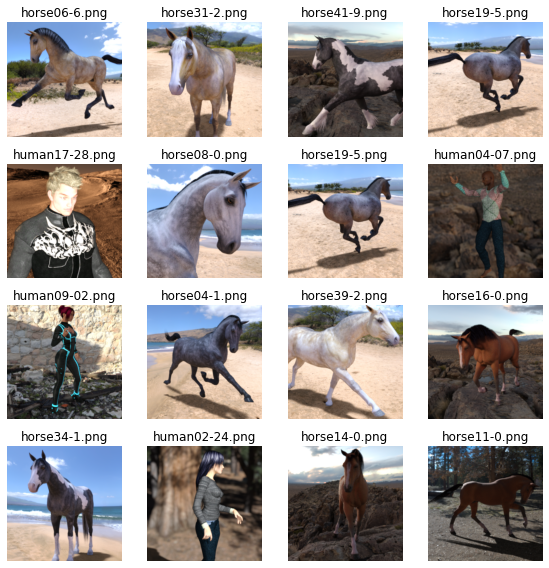

In [4]:
train_files = glob.glob('./train/*/*.png')
picked_files = random.choices(train_files, k=16)

fig = plt.figure(figsize=(8, 8))
for i, image_file in enumerate(picked_files, 1):
    ax = plt.subplot(4, 4, i)
    ax.imshow(load_img(image_file))
    ax.axis('off')
    ax.set_title(os.path.basename(image_file))

plt.tight_layout()
plt.show()

In [5]:
train_data = ImageDataGenerator(rescale=1.0/255)
train_generator = train_data.flow_from_directory(
    './train',
    target_size=(300, 300),
    batch_size=64,
    class_mode='binary'
)

val_data = ImageDataGenerator(rescale=1.0/255)
val_generator = val_data.flow_from_directory(
    './val',
    target_size=(300, 300),
    batch_size=64,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [8]:
optimizer = keras.optimizers.RMSprop(lr=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/15
17/17 [==============================] - 7s 423ms/step - loss: 0.7183 - accuracy: 0.5862 - val_loss: 0.6762 - val_accuracy: 0.5000
Epoch 2/15
17/17 [==============================] - 7s 413ms/step - loss: 0.2018 - accuracy: 0.9260 - val_loss: 2.4742 - val_accuracy: 0.6914
Epoch 4/15
17/17 [==============================] - 7s 416ms/step - loss: 0.1507 - accuracy: 0.9474 - val_loss: 1.8421 - val_accuracy: 0.8008
Epoch 5/15
17/17 [==============================] - 7s 417ms/step - loss: 0.1886 - accuracy: 0.9416 - val_loss: 1.9067 - val_accuracy: 0.7773
Epoch 6/15
17/17 [==============================] - 7s 413ms/step - loss: 0.1067 - accuracy: 0.9620 - val_loss: 2.2635 - val_accuracy: 0.8086
Epoch 7/15
17/17 [==============================] - 7s 432ms/step - loss: 0.0723 - accuracy: 0.9776 - val_loss: 0.2458 - val_accuracy: 0.9180
Epoch 8/15
17/17 [==============================] - 7s 413ms/step - loss: 0.0461 - accuracy: 0.9873 - val_loss: 2.5925 - val_accuracy: 0.7617
Epoch 

In [10]:
def read_image_file(image_file):
    img = load_img(image_file, target_size=(300, 300))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

def predict_file(image_file):
    img = read_image_file(image_file)
    classes = model.predict(img)
    if classes[0][0] > 0.5:
        print(f"{image_file} is a human")
    else:
        print(f"{image_file} is a horse")

In [11]:
predict_file('./val/horses/horse1-000.png')

./val/horses/horse1-000.png is a horse


In [12]:
# from google.colab import files

# uploaded = files.upload()

# for file in uploaded.keys():
#     predict_file(file)

In [13]:
vis_layers = model.layers[1:10]
vis_outputs = [layer.output for layer in vis_layers]
vis_model = keras.models.Model(inputs=model.input, outputs=vis_outputs)

vis_layer_names = [layer.name for layer in vis_layers]
print(f"vis_layer_names = {vis_layer_names}")

def visualize_image(image_file):
    img = read_image_file(image_file)
    vis_feature_maps = vis_model.predict(img)
    for layer_name, feature_map in zip(vis_layer_names, vis_feature_maps):
        num_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * num_features))
        for i in range(num_features):
            x = feature_map[0, :, :, i]
            if x.sum() == 0:
                continue
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

        scale = 20. / num_features
        plt.figure(figsize=(scale * num_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

vis_layer_names = ['max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'conv2d_4', 'max_pooling2d_4']


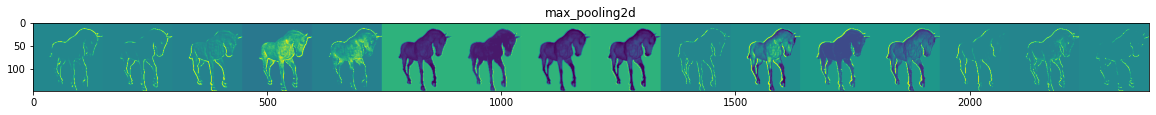

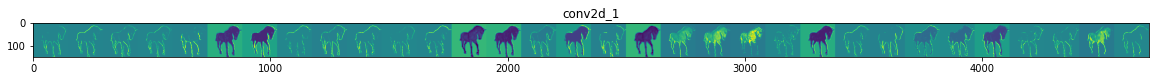

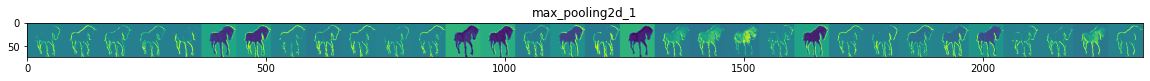

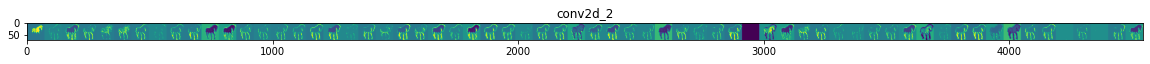

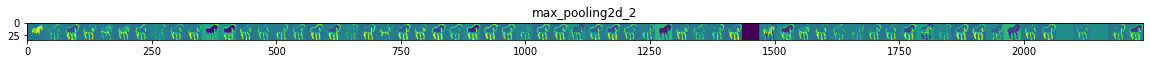

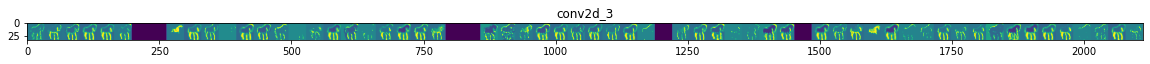

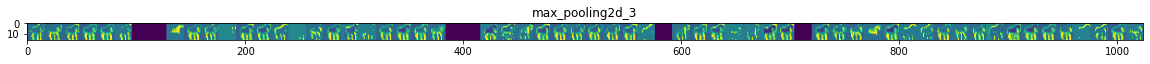

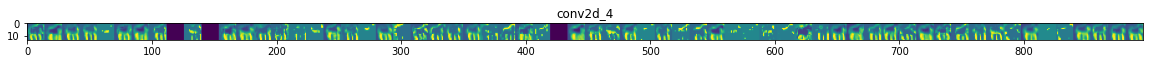

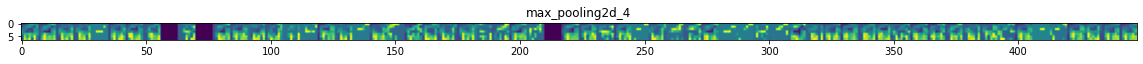

In [14]:
visualize_image('./val/horses/horse1-000.png')